In [39]:
# Import packages
import math
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# Define physical properties
length = 8  # m
delta_h = 12  # in.
thickness = 0.5  # mm
D_i = 0.8  # cm
D_o = 1.2  # cm
minor_losses = 25
V_wort = 6  # gal
T_0_wort = 200  # F
T_f_wort = 70  # F
T_city = 50  # F
P_water = 80  # psi

In [41]:
# Define material properties
k_tube = 15  # W/m*K
Nu = 50  # both sides
P_atm = 101325  # Pa
g = 9.81  # m/s^2

In [42]:
# Unit conversion functions
def in_to_m(measurement):
    return 0.0254 * measurement

def mm_to_m(measurement):
    return measurement / 1000

def cm_to_m(measurement):
    return measurement / 100

def gal_to_m3(measurement):
    return measurement * 0.00378541

def m3_to_gal(measurement):
    return measurement / 0.00378541

def f_to_c(measurement):
    return (measurement - 32) * 5 / 9

def c_to_f(measurement):
    return measurement * 9 / 5 + 32

def psi_to_pa(measurement):
    return measurement * 6894.76

In [43]:
# Temperature dependent water properties
def get_mu(temp):
    # Equation found here https://resources.saylor.org/wwwresources/archived/site/wp-content/uploads/2011/04/Viscosity.pdf
    mu = 2.414e-5 * 10 ** (247.8/(temp + 273.15 - 140))  # Pa*s
    return mu

def get_rho(temp):
    # Based off the Kell formulation (1975)
    rho = (999.83952 + 16.945176 * temp - 7.9870401e-3 * temp ** 2 - 46.170461e-6 * temp ** 3 + 105.56302e-9 * temp ** 4 - 280.54253e-12 * temp ** 5) / (1 + 16.89785e-3 * temp)  # kg/m^3
    return rho

def get_cp(temp):
    # Based off a fourth order fit of measurements from The Engineering Toolbox
    cp = 4219.4 - 2.9251 * temp + 0.0721 * temp ** 2 - 0.0007 * temp ** 3 + 3e-6 * temp ** 4  # J/kg*K
    return cp

def get_k_fluid(temp):
    # Based off second order fit of measurements from The Engineering Toolbox
    k_fluid = 0.5575 + 0.0022 * temp - 1e-5 * temp ** 2
    return k_fluid

In [44]:
# Create a pump curve object
class PumpCurve:
    def __init__(self, curve_num):
        if curve_num == 1:
            self.c1 = 1.4143  # m
            self.c2 = -0.0813  # m/lpm
            self.c3 = -0.0013  # m/lpm^2
            self.c4 = -0.0005  # m/lpm^3
            self.maxQ = 10  # lpm
        elif curve_num == 2:
            self.c1 = 2.8185
            self.c2 = -0.1978
            self.c3 = -0.0143
            self.c4 = -0.0052
            self.maxQ = 6
        elif curve_num == 3:
            self.c1 = 2.3248
            self.c2 = -0.1071
            self.c3 = -0.0045
            self.c4 = -0.0002
            self.maxQ = 12
        else:
            self.c1 = 1.4143
            self.c2 = -0.0813
            self.c3 = -0.0013
            self.c4 = -0.0005
            self.maxQ = 10
    
    def get_pump_coefficients(self):
        coefficients = [self.c1, self.c2, self.c3, self.c4]
        return coefficients
    
    def get_max_flow(self):
        return self.maxQ

In [45]:
pump1 = PumpCurve(1)
pump2 = PumpCurve(2)
pump3 = PumpCurve(3)

In [46]:
# Convert to SI units
delta_h = in_to_m(delta_h)
thickness = mm_to_m(thickness)
D_i = cm_to_m(D_i)
D_o = cm_to_m(D_o)
V_wort = gal_to_m3(V_wort)
T_0_wort = f_to_c(T_0_wort)
T_f_wort = f_to_c(T_f_wort)
T_city = f_to_c(T_city)
P_water = psi_to_pa(P_water)

# Derived values
D_h_out = D_o - (D_i + 2 * thickness)
A_in = math.pi * (D_i ** 2) / 4
A_out = math.pi * ((D_o ** 2) / 4 - ((D_i + 2 * thickness) ** 2) / 4)
rho_city = get_rho(T_city)
mu_city = get_mu(T_city)

In [47]:
# Reynolds Number Equation
def reynolds(rho, v, D, mu):
    return rho * v * D / mu

# Friction Factor Equations
def friction_factor(Re):
    return (0.79 * math.log(Re) - 1.64) ** -2

# Calculates the mean flow velocity
def u_m(pressure_grad, hydraulic_diameter, friction_factor, density):
    return math.sqrt(2 * pressure_grad * hydraulic_diameter / (friction_factor * density))

# Calculates the mass flow rate
def m_dot(velocity, area, density):
    return velocity * density * area

In [48]:
# function to calculate flow rate of the city water
def outer_flow(P_outside, f_guess):
    delta_p_city = P_outside - P_atm # Pa
    pressure_gradient = delta_p_city / length  # Pa/m
    
    # Iterate until a solution is found
    converged = False
    i = 0
    v_out = u_m(pressure_gradient, D_h_out, f_guess, rho_city)  # m/s
    print(f"Starting with f_guess = {f_guess}, v_out = {v_out}\n")
    print("Update Loop:")
    while not converged:
        Re_out = reynolds(rho_city, v_out, D_h_out, mu_city)
        f_update = friction_factor(Re_out)
        df = abs(f_update - f_guess)
        if df <= f_guess * 0.1:
            converged = True
            f_out = f_update
            Re_out = reynolds(rho_city, v_out, D_h_out, mu_city)
        else:
            f_guess = f_update
        v_out = u_m(pressure_gradient, D_h_out, f_update, rho_city)  # m/s
        i += 1
        print(f"{i}: f = {f_update}, v = {v_out}")
    
    m_dot_out = m_dot(v_out, A_out, rho_city)
    flow_type = "Turbulent" if Re_out >= 3500 else "Laminar"
    print(f"\nConverged in {i} iterations")
    print(f"Friction Factor: {f_out:.5f}")
    print(f"Reynolds Number: {Re_out:.1f}, flow is {flow_type}")
    print(f"Mean Velocity: {v_out:.2f} m/s")
    print(f"Mass Flow: {m_dot_out:.3f} kg/s")
    
    return m_dot_out, v_out, Re_out, f_out

In [49]:
# Get city water flow properties
m_dot_out, v_out, Re_out, f_out = outer_flow(P_water, 0.04)

Starting with f_guess = 0.04, v_out = 2.9062232068614464

Update Loop:
1: f = 0.03532605120888486, v = 3.0925121528329154
2: f = 0.03468318695191856, v = 3.121040926282946

Converged in 2 iterations
Friction Factor: 0.03468
Reynolds Number: 7135.9, flow is Turbulent
Mean Velocity: 3.12 m/s
Mass Flow: 0.154 kg/s


In [50]:
# Head Required as a function of Q
def h_req(flow_rate, temperature, delta_z=delta_h, diameter=D_i, L=length, K=minor_losses, grav=g):
    A = math.pi * diameter ** 2
    velocity = flow_rate / A
    rho_in = get_rho(temperature)
    mu_in = get_mu(temperature)
    Re_in = reynolds(rho_in, velocity, diameter, mu_in)
    f_in = friction_factor(Re_in)
    h_required = delta_z + (f_in * L / diameter + K) * (velocity ** 2) / (2 * grav)
    return h_required

# Calculate the intersection of the h_req curve with the pump curve
def intersection(q_set, h_pumps, h_reqs):
    q_prev = 0
    dist_prev = 0
    for i, flow_rate in enumerate(q_set):
        dist = (h_pumps[i] - h_reqs[i])
        if dist < 0:
            d_range = dist_prev - dist
            interp = dist_prev / d_range
            dq = flow_rate - q_prev
            flow = (q_prev + interp * dq) / 60_000
            return flow
        else:
            q_prev = flow_rate
            dist_prev = dist
            
# Plot the H_available from pump vs the H_required
def plot_hreq_vs_pump(temp, pump_curve, show=True):
    pump_coeffs = pump_curve.get_pump_coefficients()
    max_flow = pump_curve.get_max_flow()
    q_vals = np.linspace(0.1, max_flow, 40)
    pump_y = []
    req_y = []
    for q in q_vals:
        y_p = pump_coeffs[0] + q * pump_coeffs[1] + (q ** 2) * pump_coeffs[2] + (q ** 3) * pump_coeffs[3]
        q_m3s = q / 60_000
        y_r = h_req(q_m3s, temp)
        pump_y.append(y_p)
        req_y.append(y_r)
    
    if show:
        plt.plot(q_vals, pump_y, label='H_pump')
        plt.plot(q_vals, req_y, label='H_required')
        plt.legend()
        plt.xlabel('Flow Rate (LPM)')
        plt.ylabel('Head (m)')
        plt.title(f'Pump vs Head at {temp:.1f} C')
        plt.show()
    
    return intersection(q_vals, pump_y, req_y)

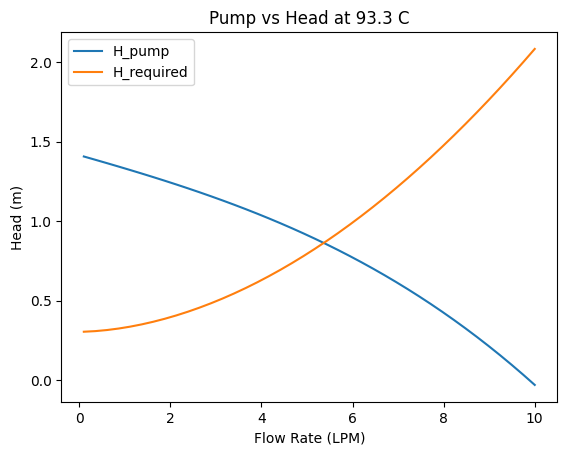

Flow Rate (inner): 0.000089 m^3/s (5.37 LPM)
Mean Velocity: 1.78 m/s
Mass Flow: 0.086


In [51]:
# plot the head curves and calculate flow rate of inner stream
rho_in_0 = get_rho(T_0_wort)
inner_flow = plot_hreq_vs_pump(T_0_wort, pump1)
v_in = inner_flow / A_in
m_dot_in = inner_flow * rho_in_0
print(f"Flow Rate (inner): {inner_flow:.6f} m^3/s ({(inner_flow * 60_000):.2f} LPM)")
print(f"Mean Velocity: {v_in:.2f} m/s")
print(f"Mass Flow: {m_dot_in:.3f}")

In [52]:
# Get convection coefficient using Nu
def convection_coefficient(nusselt, k_fluid, D):
    return nusselt * k_fluid / D

# get total thermal resistance - return UA
def thermal_resistance(d_in, t_tube, L, nusselt, k_tube, temperature):
    # Calculate values for the inside
    A_in_ht = math.pi * d_in * L
    k_in = get_k_fluid(temperature)
    h_in = convection_coefficient(nusselt, k_in, d_in)
    
    # Calculate values for the outside
    A_out_ht = math.pi * (d_in + 2 * t_tube) * L
    k_out = get_k_fluid(T_city)
    h_out = convection_coefficient(nusselt, k_out, d_in + 2 * t_tube)
    
    UA = (h_in * A_in_ht) + math.log((d_in + 2 * t_tube)/d_in) / (2 * math.pi * k_tube) + 1 / (h_out * A_out_ht)
    R_tot = 1 / UA
    return UA

def get_C(temp, m_dot):
    cp = get_cp(temp)
    return cp * m_dot

def epsilon_ntu(UA_calc, Cmin, Cr):
    NTU = UA_calc/Cmin
    if Cr < 1:
        epsilon_calc = (1 - math.exp(-NTU * (1 - Cr))) / (1 - Cr * math.exp(-NTU * (1 - Cr)))
    else:
        epsilon_calc = NTU / (1 + NTU)
    return epsilon_calc, NTU

def get_q(Cmin, T_hot_in, T_cold_in, eps):
    delta_T = T_hot_in - T_cold_in
    return Cmin * delta_T * eps

def bulk_temperature_change(heat_rate_calculated, timestep, density, cp, volume=V_wort):
    return -heat_rate_calculated * timestep / (density * volume * cp)

In [53]:
""" *** Example Calculating for a Single Iteration *** """

# Initial Heat Transfer Calculation
C_in = get_C(T_0_wort, m_dot_in)
C_out = get_C(T_0_wort, m_dot_out)
C_min = min(C_in, C_out)
C_max = max(C_in, C_out)
C_r = C_min / C_max
UA_0 = thermal_resistance(D_i, thickness, length, Nu, k_tube, T_0_wort)
epsilon_0, _ = epsilon_ntu(UA_0, C_min, C_r)
q_0 = get_q(C_min, T_0_wort, T_city, epsilon_0)
T_hot_out = - (q_0 / C_in - T_0_wort)
delta_T = T_0_wort - T_hot_out
T_cold_out = - (-q_0 / C_out - T_city)
print(f"Heat Rate: {q_0:.2f} W")
print(f"Temperature Out (hot): {T_hot_out:.1f} C")
print(f"Temperature Change: {delta_T:.1f} C")
print(f"Temperature Out (cold): {T_cold_out:.1f} C")

# Temperature change in the wort
rho_wort = get_rho(T_0_wort)
cp_wort = get_cp(T_0_wort)
delta_t = 10  # s
delta_T_wort = bulk_temperature_change(q_0, delta_t, rho_wort, cp_wort)
T_1_wort = T_0_wort + delta_T_wort
print(f"\nTemperature Change of Bulk: {delta_T_wort:.1f} C")
print(f"Updated Wort Temperature: {T_1_wort:.1f} C")

Heat Rate: 24384.24 W
Temperature Out (hot): 26.4 C
Temperature Change: 66.9 C
Temperature Out (cold): 47.3 C

Temperature Change of Bulk: -2.6 C
Updated Wort Temperature: 90.7 C


In [54]:
# Iterate through time
T_wort = T_0_wort
delta_t = 10  # s
time = 0
plot_times = []
hot_temps_in = []
hot_temps_out = []
cold_temps_out = []
wort_temps = []
print("Iterative Calculations\n")
while T_wort > T_f_wort:
    print(f"time: {time} s")
    # Append to plot lists
    plot_times.append(time)
    hot_temps_in.append(T_wort)
    wort_temps.append(T_wort)
    
    # Get updated fluid properties
    rho_in = get_rho(T_wort)
    mu_in = get_mu(T_wort)
    cp_in = get_cp(T_wort)
    k_in = get_k_fluid(T_wort)
    
    # Get flow rate of wort
    inner_flow = plot_hreq_vs_pump(T_wort, pump1, False)
    m_dot_in = inner_flow * rho_in
    print(f"Mass flow (inner): {m_dot_in:.4f} kg/s")
    
    # Heat transfer parameters
    C_in = get_C(T_wort, m_dot_in)
    C_out = get_C(T_city, m_dot_out)
    C_min = min(C_in, C_out)
    C_max = max(C_in, C_out)
    C_r = C_min / C_max
    
    # Heat transfer calculations
    UA = thermal_resistance(D_i, thickness, length, Nu, k_tube, T_wort)
    epsilon, _ = epsilon_ntu(UA, C_min, C_r)
    print(f"Epsilon: {epsilon:.5f}")
    heat_rate = get_q(C_min, T_wort, T_city, epsilon)
    print(f"Heat rate: {heat_rate:.2f} W")
    
    # Temperature calculations
    T_hot_out = - (heat_rate / C_in - T_wort)
    print(f"T_hot_out: {T_hot_out:.1f} C")
    hot_temps_out.append(T_hot_out)
    T_cold_out = (heat_rate / C_out + T_city)
    print(f"T_cold_out: {T_cold_out:.1f} C")
    cold_temps_out.append(T_cold_out)
    
    # Calculate temperature change for the bulk
    delta_T_wort = bulk_temperature_change(heat_rate, delta_t, rho_in, cp_in)
    T_wort = T_wort + delta_T_wort
    print(f"T_wort: {T_wort:.1f} C\n")
    time += delta_t

wort_temps.append(T_wort)
T_wort_F = c_to_f(T_wort)
print(f"Cooled to {T_wort:.1f} C ({T_wort_F:.1f} F) in {time} seconds ({(time / 60):.2f} minutes)")

Iterative Calculations

time: 0 s
Mass flow (inner): 0.0861 kg/s
Epsilon: 0.80197
Heat rate: 24352.65 W
T_hot_out: 26.5 C
T_cold_out: 47.6 C
T_wort: 90.7 C

time: 10 s
Mass flow (inner): 0.0861 kg/s
Epsilon: 0.80187
Heat rate: 23564.84 W
T_hot_out: 26.0 C
T_cold_out: 46.4 C
T_wort: 88.2 C

time: 20 s
Mass flow (inner): 0.0862 kg/s
Epsilon: 0.80171
Heat rate: 22802.91 W
T_hot_out: 25.5 C
T_cold_out: 45.2 C
T_wort: 85.7 C

time: 30 s
Mass flow (inner): 0.0862 kg/s
Epsilon: 0.80150
Heat rate: 22066.01 W
T_hot_out: 25.0 C
T_cold_out: 44.1 C
T_wort: 83.3 C

time: 40 s
Mass flow (inner): 0.0862 kg/s
Epsilon: 0.80127
Heat rate: 21353.34 W
T_hot_out: 24.6 C
T_cold_out: 43.0 C
T_wort: 81.0 C

time: 50 s
Mass flow (inner): 0.0862 kg/s
Epsilon: 0.80101
Heat rate: 20664.12 W
T_hot_out: 24.1 C
T_cold_out: 41.9 C
T_wort: 78.8 C

time: 60 s
Mass flow (inner): 0.0862 kg/s
Epsilon: 0.80072
Heat rate: 19997.61 W
T_hot_out: 23.7 C
T_cold_out: 40.9 C
T_wort: 76.6 C

time: 70 s
Mass flow (inner): 0.0862 kg

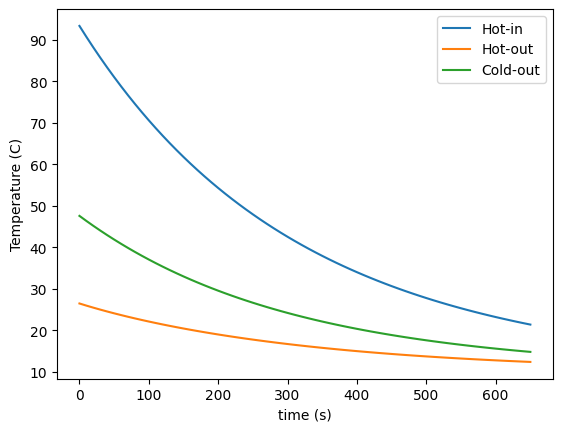

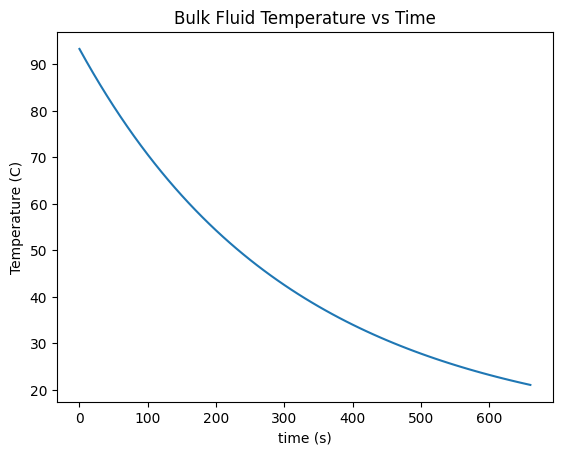

In [55]:
plt.plot(plot_times, hot_temps_in, label="Hot-in")
plt.plot(plot_times, hot_temps_out, label="Hot-out")
plt.plot(plot_times, cold_temps_out, label="Cold-out")
plt.xlabel("time (s)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

plot_times.append(time)
plt.plot(plot_times, wort_temps)
plt.xlabel("time (s)")
plt.ylabel("Temperature (C)")
plt.title("Bulk Fluid Temperature vs Time")
plt.show()

In [56]:
# Final Values
water_used = time * m_dot_out
water_used_gal = m3_to_gal(water_used / rho_city) 
print(f"Total Time Required: {time} s ({(time / 60):.2f} minutes)")
print(f"Water Used: {water_used_gal:.3f} gallons")

Total Time Required: 660 s (11.00 minutes)
Water Used: 26.925 gallons
